In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras as k
from keras.applications.vgg16 import VGG16
from keras import models
from keras import layers
from keras import optimizers


In [5]:
def plot_history(hst):
    plt.figure(figsize=(13,4))

    plt.subplot(1,2,1)
    plt.plot(hst.history['loss'],label='train')
    plt.plot(hst.history['val_loss'],label='test')
    plt.title("Loss")

    plt.subplot(1,2,2)
    plt.plot([round(100*e,2) for e in hst.history['accuracy']], label = 'train')
    plt.plot([round(100*e,2) for e in hst.history['val_accuracy']], label = 'test')
    plt.title("Accuracy")

    plt.ylim(0,100)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
import tensorflow as tf
from  keras._tf_keras.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1).astype('float32') / 255.0
x_test = np.expand_dims(x_test, axis=-1).astype('float32') / 255.0


Data preparation

In [19]:
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical

batch_size = 64

# Function to add padding
def add_padding(images, padding_width=2):
    num_images = images.shape[0]
    height, width, channels = images.shape[1], images.shape[2], images.shape[3]
    padded_height = height + 2 * padding_width
    padded_width = width + 2 * padding_width

    padded_images = np.zeros((num_images, padded_height, padded_width, channels), dtype=images.dtype)

    # Place the original images in the center of the new array
    padded_images[:, padding_width:padding_width + height, padding_width:padding_width + width, :] = images

    return padded_images

# Add padding. from 28*28 -> 32*32
x_train_padded = add_padding(x_train, padding_width=2)
x_test_padded = add_padding(x_test, padding_width=2)

#numpy to tensors
x_train_tf = tf.convert_to_tensor(x_train_padded, dtype=tf.float32)
x_test_tf = tf.convert_to_tensor(x_test_padded, dtype=tf.float32)

# grayscale to RGB
x_train_rgb_tf = tf.image.grayscale_to_rgb(x_train_tf)
x_test_rgb_tf = tf.image.grayscale_to_rgb(x_test_tf)

# labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

# Convert one-hot encoded labels to tensors
y_train_tf = tf.convert_to_tensor(y_train_one_hot, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test_one_hot, dtype=tf.float32)

# Create TensorFlow datasets with batches
train_data = tf.data.Dataset.from_tensor_slices((x_train_rgb_tf, y_train_tf)).shuffle(buffer_size=10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices((x_test_rgb_tf, y_test_tf)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("Original shape:", x_train.shape)
print("Padded shape:", x_train_padded.shape)
print("Padded+RGB shape:", x_train_rgb_tf.shape)


Original shape: (60000, 28, 28, 1)
Padded shape: (60000, 32, 32, 1)
Padded+RGB shape: (60000, 32, 32, 3)


**Feature-based**

In [20]:
epochs = 10
steps_per_epoch = 200
validation_steps = 50

n_hidden_1 = 128
n_hidden_2 = 64
activation_function_l1 = 'relu'
activation_function_l2 = 'relu'

optimizer = 'adam' 
loss_func = "categorical_crossentropy"
metrics = "accuracy"

# learning_rate = 0.005
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

dropout = 0.2

In [21]:
# VGG16
conv_base = VGG16(weights="imagenet", include_top=False, input_shape=(32, 32, 3))
conv_base.trainable = False

model = models.Sequential([
   conv_base,
   layers.Flatten(),
   layers.Dense(n_hidden_1, activation=activation_function_l1),
   layers.Dropout(dropout),
   layers.Dense(n_hidden_2, activation=activation_function_l2),
   layers.Dropout(dropout),
   layers.Dense(10, activation='softmax')
])

model.compile(
    loss=loss_func,
    optimizer=optimizer,
    metrics=[metrics]
)

conv_base.summary(show_trainable=True)

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_7 (InputLayer)  │ (None, 32, 32, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 32, 32, 64)    │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 32, 32, 64)    │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 16, 16, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 16, 16, 128)   │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 16, 16, 128)   │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 8, 8, 128)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 8, 8, 256)     │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 8, 8, 256)     │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 8, 8, 256)     │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 4, 4, 256)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 4, 4, 512)     │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 4, 4, 512)     │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 4, 4, 512)     │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 2, 2, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 2, 2, 512)     │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 2, 2, 512)     │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 2, 2, 512)     │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 1, 1, 512)     │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 902ms/step - accuracy: 0.3950 - loss: 1.7657 - val_accuracy: 0.7522 - val_loss: 0.7717
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.7018 - loss: 0.8502 - val_accuracy: 0.7625 - val_loss: 0.6578
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 96s 965ms/step - accuracy: 0.7412 - loss: 0.7331 - val_accuracy: 0.7816 - val_loss: 0.6049
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 727ms/step - accuracy: 0.7616 - loss: 0.6719 - val_accuracy: 0.8225 - val_loss: 0.5352
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 865ms/step - accuracy: 0.7788 - loss: 0.6055 - val_accuracy: 0.8100 - val_loss: 0.5197
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 836ms/step - accuracy: 0.7877 - loss: 0.6098 - val_accuracy: 0.8131 - val_loss: 0.5224
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 827ms/step - accuracy: 0.8132 - loss: 0.5391 - val_accuracy: 0.8250 - val_loss: 0.4922
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 59s 586ms/step - accuracy: 0.8157 - loss: 0.5

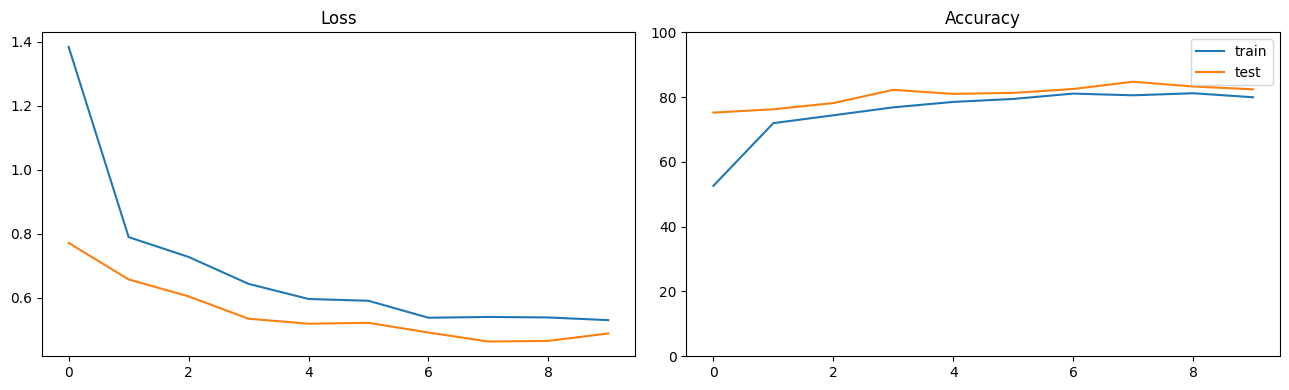

In [22]:
history = model.fit(
    train_data,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    validation_steps=validation_steps,
    validation_data=test_data
)
plot_history(history)


**best result is**


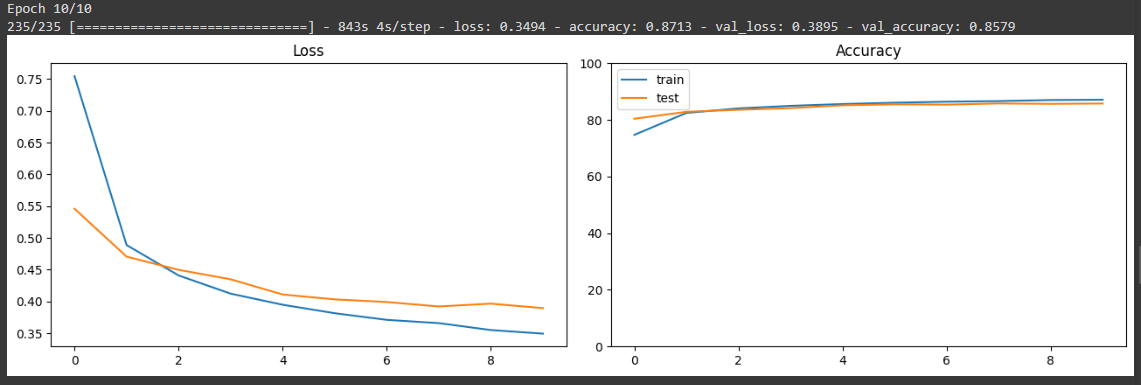

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 605ms/step


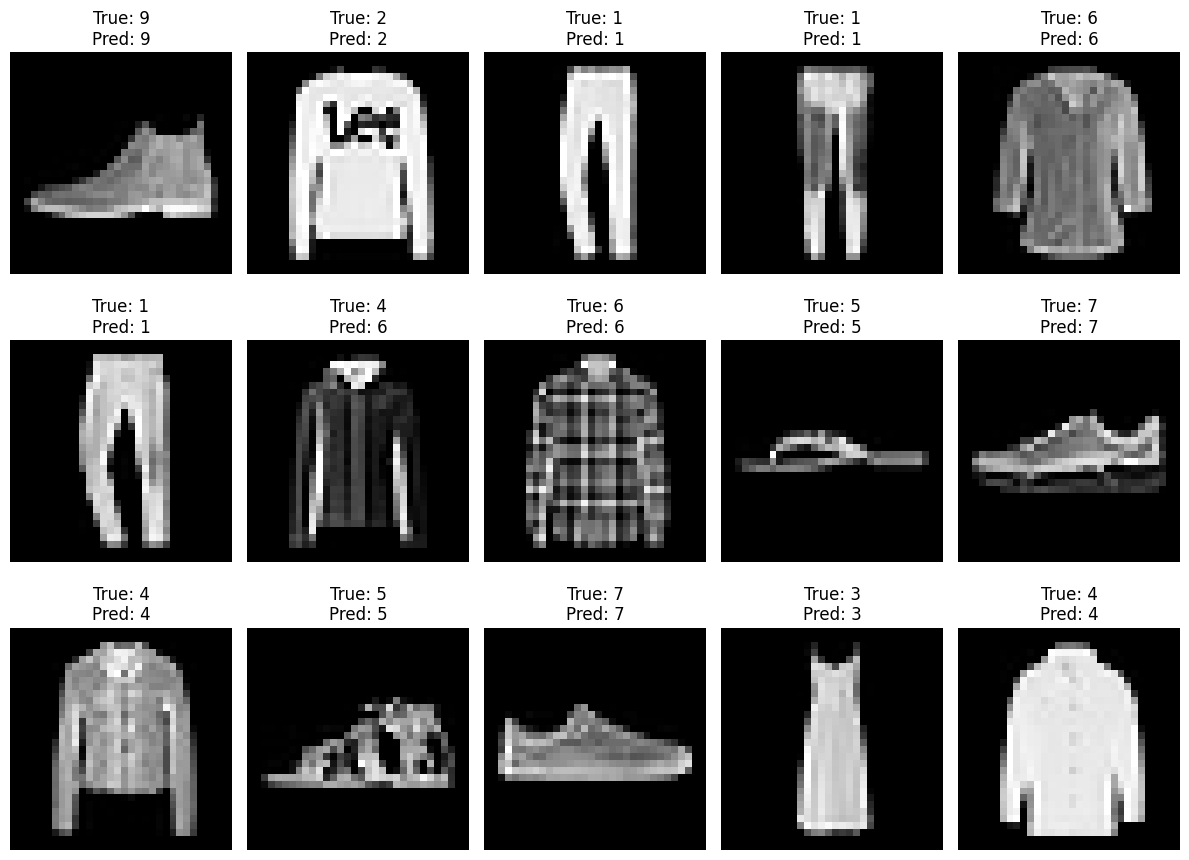

In [15]:
import numpy as np
import matplotlib.pyplot as plt

rows = 3

# Function to get a batch from the dataset
def get_batch(dataset):
    for images, labels in dataset.take(1):  # Take one batch
        return images.numpy(), labels.numpy()  # Convert to numpy arrays

# Get a batch of images and labels
images_batch, labels_batch = get_batch(test_data)


# Make predictions
predictions = model.predict(images_batch)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(labels_batch, axis=1)  # Convert one-hot encoded labels to class indices

def plot_random_predictions(images, true_labels, pred_labels, num_rows = 3, num_images=15):
    plt.figure(figsize=(12, num_rows * 3))
    
    for i in range(num_images):
        plt.subplot(num_rows, 5, i + 1)
        plt.imshow(images[i])  # Display image
        plt.title(f'True: {true_labels[i]}\nPred: {pred_labels[i]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 15 images with their predictions
plot_random_predictions(images_batch[:15], true_labels[:15], predicted_labels[:15])
